[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GuilhermeFreire/ColorAE/blob/master/ColorAE.ipynb)

## Imports & boilerplate stuff

In [1]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
base_folder = "./images"
if not os.path.isdir(base_folder):
    os.mkdir(base_folder)

In [3]:
# device selection
mode = "gpu"
device_idx = 0
if mode == "gpu":
    device = torch.device(f"cuda:{device_idx}" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

cpu


## Autoencoder Model

We define the model as a simple two layer autoencoder. The model is ready to receive a 3-dimensional vector as input, compresses it into two dimensions and expands that representation back into 3 dimensions.

Note that there isn't a specific color encoding 

In [4]:
class ColorAE(torch.nn.Module):
    def __init__(self):
        super(ColorAE, self).__init__()
        self.encoder = torch.nn.Linear(3, 2)
        self.decoder = torch.nn.Linear(2, 3)
    
    def encode(self, x):
        return torch.sigmoid(self.encoder(x))
    
    def decode(self, x):
        return torch.sigmoid(self.decoder(x))
    
    def forward(self, x):
        return self.decode(self.encode(x))

In [5]:
class ColorDatasetTriplet(torch.utils.data.Dataset):
    def __init__(self, size, nudge=0.005):
        self.size = size
        self.nudge = nudge
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, _):
        anchor = torch.rand(3)
        nudge = (torch.rand(3) - 0.5) * 2 * self.nudge
        similar = anchor + nudge
        while True:
            not_similar = torch.rand(3)
            if (not_similar - anchor).norm() > self.nudge:
                return anchor, similar, not_similar

In [6]:
model = ColorAE().to(device)
lr = 1e-3
batch_size = 64
opt = torch.optim.Adam(model.parameters(), lr)
train_dataset = ColorDatasetTriplet(10000)
print(model)

ColorAE(
  (encoder): Linear(in_features=3, out_features=2, bias=True)
  (decoder): Linear(in_features=2, out_features=3, bias=True)
)


In [7]:
def convert(c, color_space="RGB"):
    if color_space == "RGB":
        return (255 * c).int()
    else:
        raise ValueError("Invalid color space")

def visualize_model(model, w=200, h=200, save_path=None):
    model.eval()
    with torch.no_grad():
        final_image = torch.zeros(h, w, 3, dtype=torch.uint8, device="cpu")
        xs = torch.linspace(0, 1, w)
        ys = torch.linspace(0, 1, h)
        for i, y in enumerate(ys):
            for j, x in enumerate(xs):
                point = torch.stack([x, y], dim=0).to(device)
                color = convert(model.decode(point).to("cpu"))
                final_image[i,j] = color
        if save_path:
            im = Image.fromarray(final_image.numpy())
            im.save(save_path)
        else:
            plt.imshow(final_image)
            plt.show()

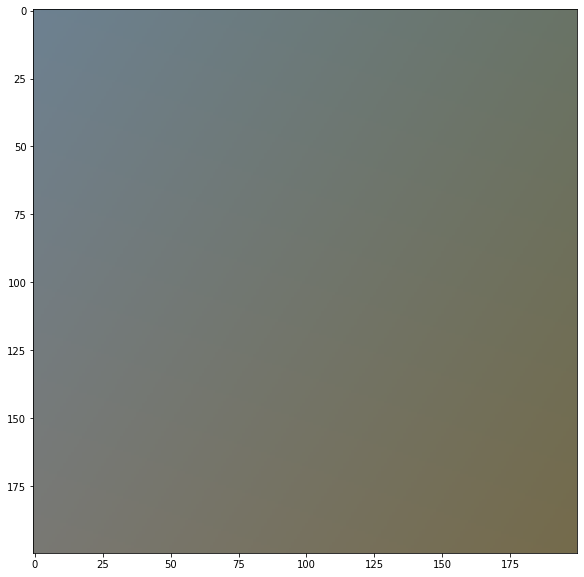

In [8]:
plt.figure(figsize=(10,10))
visualize_model(model)

In [9]:
test_dataset = ColorDatasetTriplet(10000)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=16)
def evaluate_model(model):
    model.eval()
    loss = 0
    with torch.no_grad():
        for anchors, similars, not_similars in test_loader:
            anchors = anchors.to(device)
            similars = similars.to(device)
            not_similars = not_similars.to(device)
            enc_anchors = model.encode(anchors)
            enc_similars = model.encode(similars)
            enc_not_similars = model.encode(not_similars)
            rec_anchors = model.decode(enc_anchors)
            loss += compute_loss(enc_anchors, enc_similars, enc_not_similars, anchors, rec_anchors).item()
        return loss * batch_size / len(test_loader)

In [10]:
reconstruction_loss = torch.nn.MSELoss()
similarity_loss = torch.nn.TripletMarginLoss()

def compute_loss(anchor, similar, not_similar, og_anchor, pr_anchor, w=1.0):
    triplet_loss = similarity_loss(anchor, similar, not_similar)
    rec_loss = reconstruction_loss(og_anchor, pr_anchor)
    return rec_loss + w * triplet_loss

In [11]:
def train(model, epochs=120):
    train_losses = []
    test_losses = []
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
    for epoch in range(epochs):
        opt.zero_grad()
        model.train()
        epoch_train_loss = 0
        for anchors, similars, not_similars in train_loader:
            anchors = anchors.to(device)
            similars = similars.to(device)
            not_similars = not_similars.to(device)
            enc_anchors = model.encode(anchors)
            enc_similars = model.encode(similars)
            enc_not_similars = model.encode(not_similars)
            rec_anchors = model.decode(enc_anchors)
            loss = compute_loss(enc_anchors, enc_similars, enc_not_similars, anchors, rec_anchors)
            loss.backward()
            opt.step()
            epoch_train_loss += loss.item()
        epoch_train_loss /= len(train_loader) / batch_size
        test_loss = evaluate_model(model)
        visualize_model(model, save_path=os.path.join(base_folder, f"reduced_{epoch:04d}.png"))
        train_losses.append(epoch_train_loss)
        test_losses.append(test_loss)
        print(f"Training loss: {epoch_train_loss}; Test loss: {test_loss}")
    return train_losses, test_losses
        
train_losses, test_losses = train(model)

Training loss: 63.735638539502574; Test loss: 62.244105126447735
Training loss: 61.43280896715298; Test loss: 60.037117709020144
Training loss: 59.35258459589284; Test loss: 57.968177601030675
Training loss: 57.34152671182232; Test loss: 56.11221442252967
Training loss: 55.25618486343675; Test loss: 54.2256024111608
...
Training loss: 20.88592125959457; Test loss: 21.30699142528947
Training loss: 20.638960309848663; Test loss: 20.642963883223807


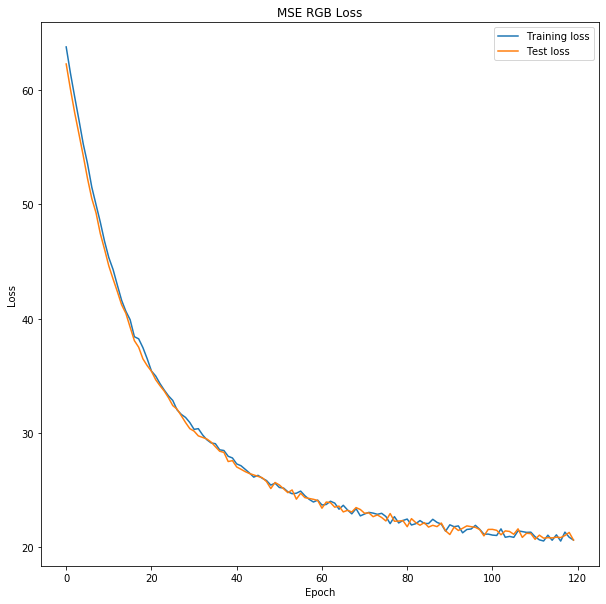

In [12]:
plt.figure(figsize=(10, 10))
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Test loss")
plt.title("MSE RGB Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()